In [6]:
# Import machine-learning packages
import torch
from torch import nn

# Import plotting packages
from IPython.display import Image, HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import time
import base64
import numpy as np
import random

%matplotlib inline

# Creating Data-Sets

In [2]:
import xarray as xr

In [3]:
data = xr.open_dataset("../data4training/icepack.h.20150101.nc", decode_times=False)
input_vars = ["vice", "sst", "sss", "Tair", "Qa", "frain", "fsnow", "flw", "fsw"]
data_x = []
for var in input_vars:
    data_x += [data[var].values[:-1, 2]]
data_y = data.vice.values[1:,2]

## Partitioning Data

In [7]:
num_t = len(data_x[0])
ind = np.arange(num_t)
train_prop, val_prop, test_prop = 0.7, 0.15, 0.15

# 10 days train, 2 days validation, 2 days test
index_train = [i for i in ind if i % (14 * 24) in np.arange(10 * 24)]
index_val = [i for i in ind if i % (14 * 24) in np.arange(10 * 24, 12 * 24)]
index_test = [i for i in ind if i % (14 * 24) in np.arange(12 * 24, 14 * 24)]

print("Train, first and last: ", [index_train[0], index_train[-1]])
print("Validation, first and last: ", [index_val[0], index_val[-1]])
print("Test, first and last: ", [index_test[0], index_test[-1]])
print("Train set size: ", len(index_train))
print("Validation set size: ", len(index_val))
print("Test set size: ", len(index_test))
print("Sum of sizes:", sum([len(index_train), len(index_val), len(index_test)]))

# shuffle training and validation sets in place
random.shuffle(index_train)
random.shuffle(index_val)

Train, first and last:  [0, 8758]
Validation, first and last:  [240, 8687]
Test, first and last:  [288, 8735]
Train set size:  6263
Validation set size:  1248
Test set size:  1248
Sum of sizes: 8759


### Creating Training Set

In [8]:
n = len(index_train)
x = torch.ones(n,9)
y = torch.ones(n,1)
for i in range(n):
    for j in range(9):
        x[i][j]= data_x[j][index_train[i]]
    y[i] = data_y[index_train[i]]

### Creating Validation Set

In [34]:
n = len(index_val)
x_val = torch.ones(n,9)
y_val = torch.ones(n,1)
for i in range(n):
    for j in range(9):
        x_val[i][j]= data_x[j][index_val[i]]
    y_val[i] = data_y[index_val[i]]

Check if normalized or not:

In [18]:
print(min(x[:,0]), max(x[:,0]))


tensor(2.3080) tensor(3.4442)


# Defintion Neural Network

In [19]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense1 = nn.Linear(9, 30)
        self.Dense2 = nn.Linear(30, 30)
        self.Dense3 = nn.Linear(30, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.Dense1(x)
        x = self.relu(x)
        x = self.Dense2(x)
        x = self.relu(x)
        x = self.Dense3(x)

        return x
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(9, 30)  
        self.linear2 = nn.Linear(30, 20)
        self.linear3 = nn.Linear(20, 1)  

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x


In [9]:
neural_net = Simple_Neural_Net()

In [42]:
neural_net = FCNN()

In [43]:
# Here we use the Adam optimizer.
learning_rate = 0.005
optimizer = torch.optim.Adam(neural_net.parameters())

In [44]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

# Training

In [38]:
def train_step(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(x)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()
    return loss

In [45]:
def validate_step(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(x_val)
    loss = loss_fn(pred, y_val)

    loss = loss.item()
    return loss

In [46]:
epochs = 1000
Loss = np.zeros(epochs)
V_Loss = np.zeros(epochs)
for t in range(epochs):
    Loss[t] = train_step(neural_net, loss_fn, optimizer)
    V_Loss[t] = validate_step(neural_net, loss_fn, optimizer)
    if np.mod(t, 200) == 0:
        print(f"Loss at Epoch {t+1} is ", Loss[t])

Loss at Epoch 1 is  48.849246978759766
Loss at Epoch 201 is  0.01355372928082943
Loss at Epoch 401 is  0.007862293161451817
Loss at Epoch 601 is  0.006884241010993719
Loss at Epoch 801 is  0.006446984596550465


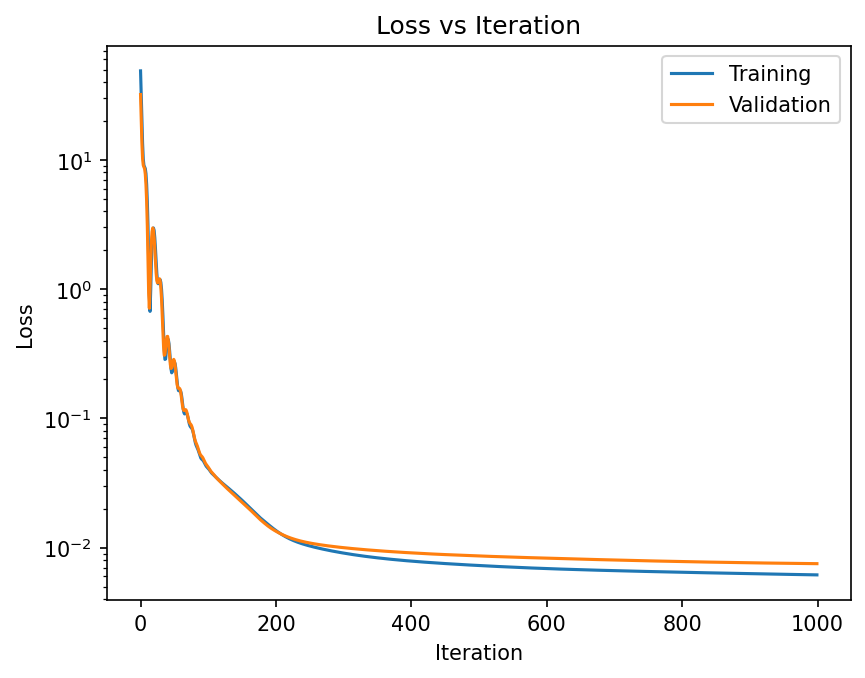

In [47]:
plt.figure(dpi=150)
plt.plot(Loss, label = "Training")
plt.plot(V_Loss, label = "Validation")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.legend()
plt.show()

# Testing

### Creating Test-Data-Set

In [26]:
n = len(index_test)
xt = torch.ones(n,9)
for i in range(n):
    for j in range(9):
        xt[i][j]= data_x[j][index_test[i]]

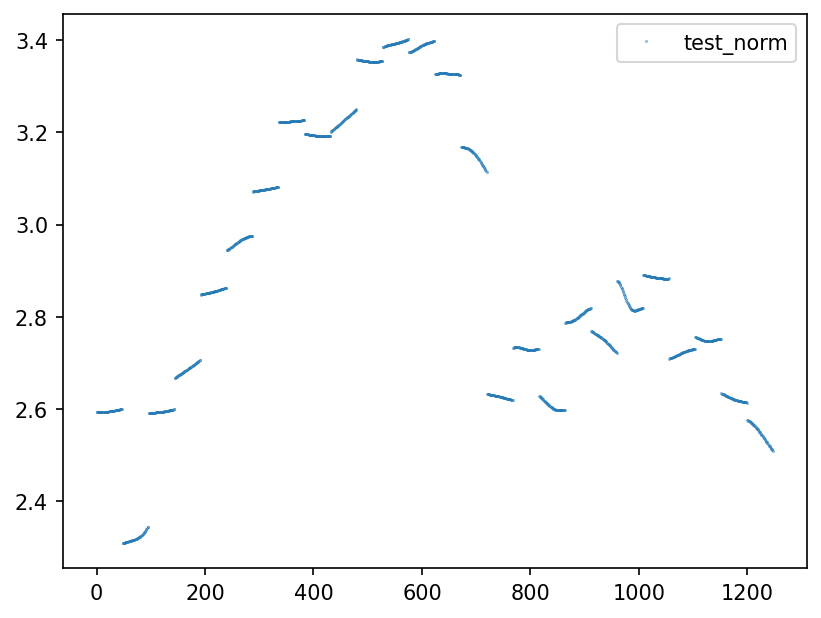

In [27]:
plt.figure(dpi=150)
plt.plot(xt[:,0], ".",markersize=0.5, label="test_norm")

plt.legend()

In [28]:
# Generate some points where the predictions of the model will be tested.
# Here we pick the testing domain to be larger than the training domain to check if the model
# has any skill at extrapolation.

y_ml_pred = torch.zeros(len(index_test)+1)
x_test = torch.ones(9)
for i in range(len(index_test)):
    for j in range (1,9):  # to avoid writing in the place of predicted field 
        x_test[j] = xt[i,j]
    if i == 0:
        x_test[0] = xt[0,0]
    else:
        x_test[0] = pred
    pred = neural_net(x_test).detach().numpy()
    pred = torch.from_numpy(pred)
    y_ml_pred[i+1] = pred 

# store icepack output for comparison with predicted result
y_test = torch.ones(len(index_test))
for i in range(len(index_test)):
    y_test[i] = data_y[index_test[i]]

## Comparing prediction to ICEPACK-Data

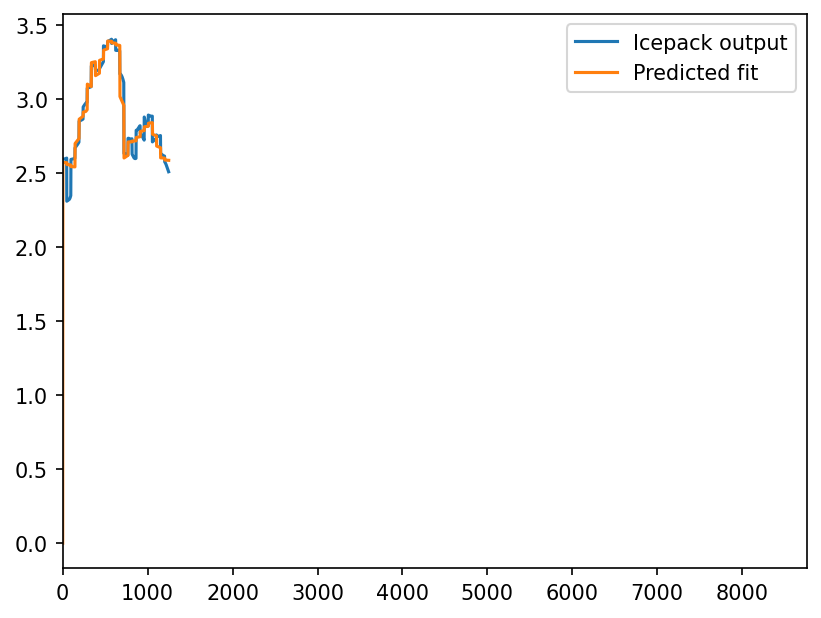

In [29]:
plt.figure(dpi=150)

plt.plot(y_test, markersize=0.5, label="Icepack output")
plt.plot(y_ml_pred, markersize=0.5, label="Predicted fit")
plt.xlim(0,8760)
plt.legend()

## Difference between prediction and ICEPACK-Data

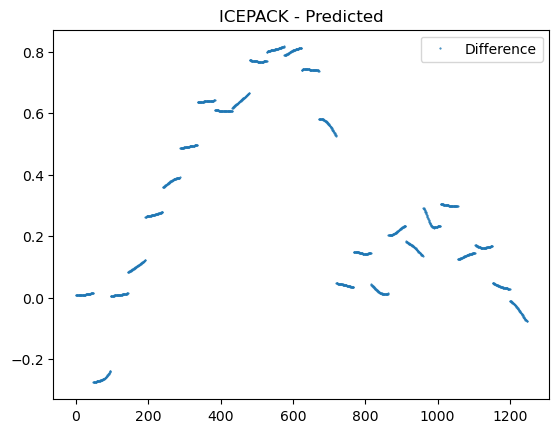

In [30]:
plt.plot(y_test - pred.flatten(), 'o', markersize=0.5, label = 'Difference');
plt.title("ICEPACK - Predicted");
plt.legend();

# Validation